<a href="https://colab.research.google.com/github/AdarshKammar/Python/blob/main/Unet_model__TF_Keras_using_Oxford_IIIT_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random

def download_and_extract():
    !wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
    !wget -q http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
    !tar -xzf images.tar.gz && tar -xzf annotations.tar.gz

download_and_extract()



In [3]:

# Define paths
IMAGE_DIR = "images"
ANNOTATION_DIR = "annotations/trimaps"

def load_image_and_mask(image_file):
    image_path = os.path.join(IMAGE_DIR, image_file)
    mask_path = os.path.join(ANNOTATION_DIR, image_file.replace(".jpg", ".png"))

    image = cv2.imread(image_path)
    if image is None:
        return None, None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        return None, None
    mask = cv2.resize(mask, (128, 128))
    mask = np.where(mask == 2, 1, 0)  # Convert to binary segmentation

    return image / 255.0, np.expand_dims(mask, axis=-1)

In [4]:

def dataset_generator():
    image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith(".jpg")]
    for img in image_files:
        img_arr, msk_arr = load_image_and_mask(img)
        if img_arr is not None and msk_arr is not None:
            yield img_arr, msk_arr

dataset = tf.data.Dataset.from_generator(dataset_generator, output_signature=(
    tf.TensorSpec(shape=(128, 128, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(128, 128, 1), dtype=tf.uint8)))

dataset = dataset.batch(16).shuffle(100)
train_size = int(0.8 * len(list(dataset)))
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)

In [5]:


def unet_model(input_size=(128, 128, 3)):
    inputs = keras.Input(input_size)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u4 = layers.UpSampling2D((2, 2))(c3)
    u4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.concatenate([u4, c2])
    u4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u4)

    u5 = layers.UpSampling2D((2, 2))(u4)
    u5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    u5 = layers.concatenate([u5, c1])
    u5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u5)

    model = keras.Model(inputs, outputs)
    return model

model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, validation_data=test_dataset, epochs=10)


Epoch 1/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 99s 229ms/step - accuracy: 0.6496 - loss: 0.6445 - val_accuracy: 0.7565 - val_loss: 0.5029
Epoch 2/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 90s 224ms/step - accuracy: 0.7720 - loss: 0.4829 - val_accuracy: 0.7864 - val_loss: 0.4632
Epoch 3/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - accuracy: 0.8102 - loss: 0.4221 - val_accuracy: 0.8288 - val_loss: 0.3874
Epoch 4/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 89s 225ms/step - accuracy: 0.8331 - loss: 0.3795 - val_accuracy: 0.8387 - val_loss: 0.3663
Epoch 5/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 89s 225ms/step - accuracy: 0.8490 - loss: 0.3504 - val_accuracy: 0.8376 - val_loss: 0.3572
Epoch 6/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 142s 370ms/step - accuracy: 0.8590 - loss: 0.3303 - val_accuracy: 0.8663 - val_loss: 0.3145
Epoch 7/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 142s 371ms/step - accuracy: 0.8659 - loss: 0.3175 - val_accuracy: 0.8404 - val_loss: 0.3579
Epoch 8/10
369/369 ━━━━━━━━━━━━━━━━━━━━ 89s 225ms/step - accuracy: 0.8680 - loss

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 656ms/step


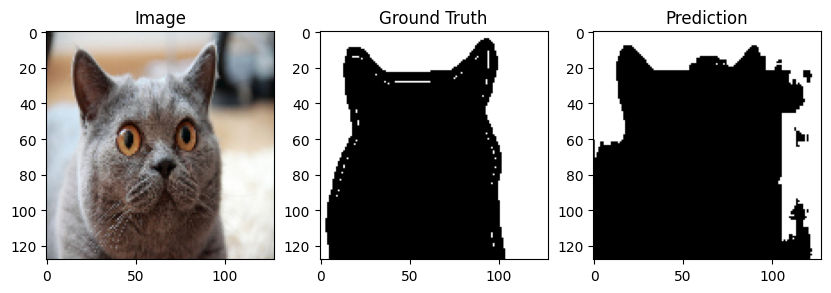

In [6]:

def plot_sample(image, mask, pred):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    axes[0].imshow(image)
    axes[0].set_title("Image")
    axes[1].imshow(mask.squeeze(), cmap='gray')
    axes[1].set_title("Ground Truth")
    axes[2].imshow(pred.squeeze(), cmap='gray')
    axes[2].set_title("Prediction")
    plt.show()

sample = next(iter(test_dataset))
pred = model.predict(sample[0])
pred = (pred > 0.5).astype(np.uint8)
plot_sample(sample[0][0].numpy(), sample[1][0].numpy(), pred[0])